<h1 align='center'><b><font color='indianred'></p>Spam Detection</b></h1>

<font color = 'indianred' size = 4 >**Instructions** </font>


# <font color='indianred'> **Load the dataset**

- In this project, I used spam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. I uploaded this data in my github repo. I loaded the data in pandas dataframe

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Renamed columns as label and message

- Found the %  ham amd spam in the data.





# <font color='indianred'> **The metric for evaluating models**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So it is necessary to choose a different metric.

Task: To find a suitable metric to evaluate the model.

# <font color='indianred'> **Classification Pipelines**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* I used the folllowing methods to create features which were used in the model.

    1. Sparse Embeddings (TF-IDF)
    2. Feature Engineering
    3. Sparse Embeddings (TF-IDF) + Feature Engineering

**Approach:**

<font color='indianred'> ****Used a smaller subset of dataset (e.g. 5-10 %) to evaluate the three pipelines . Based on the analysis (e.g. model score, learning curves) , I chose one pipeline from the three and provided rationale for choosing the pipleine. Finally, I trained the desired final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:**

1. We can use any ML model (Logistic Regression, XgBoost) for the classification. It is necessary to tune the **model for imbalanced dataset**.

2. For feature engineering, one can choose from the examples below.

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes etc.).

3. For Sparse embeddings I used **tfidf vectorization**. It is necessary to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.).

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. So I used RandomizedSearch.**</font>





In [1]:
import os
import sys
import joblib

import numpy as np
import pandas as pd

# Import scikit-learn classes for building models
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [2]:
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/spam.csv"

--2024-05-16 20:29:18--  https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv.2’

spam.csv.2          100%[===================>] 491.86K  --.-KB/s    in 0.07s   

2024-05-16 20:29:18 (6.71 MB/s) - ‘spam.csv.2’ saved [503663/503663]



In [3]:
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/CustomPreprocessorSpacy.py"
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/FeaturizerSpacy.py"
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/plot_learning_curve.py"

--2024-05-16 20:29:20--  https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/CustomPreprocessorSpacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7763 (7.6K) [text/plain]
Saving to: ‘CustomPreprocessorSpacy.py.1’

CustomPreprocessorS 100%[===================>]   7.58K  --.-KB/s    in 0s      

2024-05-16 20:29:20 (33.1 MB/s) - ‘CustomPreprocessorSpacy.py.1’ saved [7763/7763]

--2024-05-16 20:29:20--  https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/FeaturizerSpacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.

In [4]:
!pip install -U nltk -qq
!pip install -U spacy -qq
!python -m spacy download en_core_web_sm -qq

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import CustomPreprocessorSpacy as cp
from FeaturizerSpacy import ManualFeatures
from plot_learning_curve import plot_learning_curve

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [6]:
df=pd.read_csv('spam.csv',encoding="ISO-8859-1")
df.rename(columns={'v1':'label','v2':'message'},inplace=True)
df=df.iloc[:,:2]
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#data balance check
print('label balance : ',
      df.label.value_counts()['ham']/
      df.label.value_counts()['spam'])

label balance :  6.459170013386881


In [8]:
#see 5 sample texts
#pd.options.display.max_colwidth = 10
for i in np.random.randint(0,len(df),5):
  print(df['label'][i]+' : '+df['message'][i])

ham : I.ll get there tomorrow and send it to you
ham : For many things its an antibiotic and it can be used for chest abdomen and gynae infections even bone infections.
ham : Yun buying... But school got offer 2000 plus only...
ham : Ok...
ham : How would my ip address test that considering my computer isn't a minecraft server


In [9]:
df_small=df.sample(frac=0.05, replace=False, random_state=22)
df_large=df.sample(frac=0.5, replace=False, random_state=22)

In [10]:
#data balance check
print(df_small.label.value_counts()['ham']/
      df_small.label.value_counts()['spam'])

print(df_large.label.value_counts()['ham']/
      df_large.label.value_counts()['spam'])

6.342105263157895
6.509433962264151


# Preprocessing

In [11]:
df_small.label.replace({'ham': 0, 'spam': 1},inplace=True)
df_large.label.replace({'ham': 0, 'spam': 1},inplace=True)

joblib.dump(df_large, 'df_large.pkl')

['df_large.pkl']

In [27]:
preprocessor=cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 500)

In [28]:
pd.options.display.max_colwidth = 100

df_sample=df_small.copy()
df_sample['after']=preprocessor.fit_transform(df_sample['message'].tolist())
df_sample[df_sample['label']==1].head(10)

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,label,message,after
5342,1,"u r subscribed 2 TEXTCOMP 250 wkly comp. 1st wk?s free question follows, subsequent wks charged@...",u r subscribe 2 textcomp 250 wkly comp 1st wk?s free question follow subsequent wks charged@150p...
1216,1,You have 1 new voicemail. Please call 08719181513.,1 new voicemail 08719181513
4726,1,"Had your mobile 10 mths? Update to the latest Camera/Video phones for FREE. KEEP UR SAME NUMBER,...",mobile 10 mth update late camera video phone free ur number extra free min text text yes
2547,1,"Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions: info@txt82228....",text82228 > > ringtone logo game question
3012,1,FREE UNLIMITED HARDCORE PORN direct 2 your mobile Txt PORN to 69200 & get FREE access for 24 hrs...,free unlimited hardcore porn direct 2 mobile txt porn 69200 free access 24 hrs chrgd@50p day txt...
2943,1,We currently have a message awaiting your collection. To collect your message just call 08718723...,currently message await collection collect message 08718723815
3121,1,Free entry in 2 a weekly comp for a chance to win an ipod. Txt POD to 80182 to get entry (std tx...,free entry 2 weekly comp chance win ipod txt pod 80182 entry std txt rate t&c apply 08452810073 ...
190,1,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk,unique find 30th august
374,1,"Thanks for your Ringtone Order, Reference T91. You will be charged GBP 4 per week. You can unsub...",thank ringtone order reference t91 charge gbp 4 week unsubscribe anytime call customer service 0...
3903,1,Your 2004 account for 07XXXXXXXXX shows 786 unredeemed points. To claim call 08719181259 Identif...,2004 account 07xxxxxxxxx show 786 unredeemed point claim 08719181259 identifier code xxxxx expir...


# Modeling

In [29]:
class module:
  def __init__(self,X,y,preprocessor,pipeline,params,sparse=False,featurize=False):
    self.X=X
    self.y=y
    self.preprocessor=preprocessor
    self.pipeline=pipeline

    self.params=params

    # Boolean parameters
    self.sparse=sparse
    # if sparse is true, pipeline should include vectorizer
    self.featurize=featurize

    # Featuerizer
    self.featurizer=ManualFeatures(spacy_model='en_core_web_sm',
                                   batch_size = 1000)

  def __call__(self,**kwargs):
    '''
    run the whole module

    preprocessing
    spliting
    feature engineering
    randomsearch
    train report
    test report
    '''

    #preprocessing
    X_train, X_test, y_train, y_test=self._preprocessing()

    #feature engineering
    _,__=self._feature_engineering(X_train, X_test, y_train, y_test,**kwargs)

    #random CV fitting
    self._fit(self.X_train,self.y_train)

    #report train result
    self._train_report()

    #report test result
    self._predict(self.X_test,self.y_test)

  def _preprocessing(self):
    '''
    This process use preprocessor and split data

    split ratio is 0.8:0.2

    '''

    from sklearn.model_selection import train_test_split
    self.X_preprocessing=self.preprocessor.fit_transform(self.X)

    #return X_train, X_test, y_train, y_test
    return train_test_split(self.X_preprocessing,
                            self.y,
                            test_size=0.2,
                            random_state=42)

  def _feature_engineering(self,X_train, X_test, y_train, y_test,**kwargs):

    '''
    kwargs finds specific features the model will use

    '''
    R=['count_words','count_characters','count_characters_no_space',
     'avg_word_length','count_numbers', 'count_sentences',
     'noun_count', 'aux_count', 'verb_count', 'adj_count', 'ner']

    if 'featurizer_items' in kwargs.keys():
      L=kwargs['featurizer_items']
      N = [i for i in range(len(L)) if L[i] in R]

    #case 1
    if (self.featurize==True) and (self.sparse==False):
      X_train_feature,_=self.featurizer.fit_transform(X_train)
      X_test_feature,_=self.featurizer.fit_transform(X_test)
      if 'featurizer_items' in kwargs.keys():
        X_train_feature=X_train_feature[:, N]
        X_test_feature=X_test_feature[:, N]

      self.X_train=X_train_feature
      self.y_train=y_train
      self.X_test=X_test_feature
      self.y_test=y_test
    #case 2
    elif (self.featurize==False) and (self.sparse==True):
      self.X_train=X_train
      self.y_train=y_train
      self.X_test=X_test
      self.y_test=y_test
    #case 3
    elif (self.featurize==True) and (self.sparse==True):
      X_train_feature,_=self.featurizer.fit_transform(X_train)
      X_test_feature,_=self.featurizer.fit_transform(X_test)
      if 'featurizer_items' in kwargs.keys():
        X_train_feature=X_train_feature[:, N]
        X_test_feature=X_test_feature[:, N]
        feature_names=[R[i] for i in N]
      else:
        feature_names=R
      self.X_train= pd.concat((pd.DataFrame(X_train, columns=['cleaned_text']),
                               pd.DataFrame(X_train_feature, columns=feature_names)), axis=1)
      self.y_train=y_train
      self.X_test= pd.concat((pd.DataFrame(X_test, columns=['cleaned_text']),
                               pd.DataFrame(X_test_feature, columns=feature_names)), axis=1)
      self.y_test=y_test
    else :

      raise Exception('check sparseembedding or featurizer')

    return self.X_train,self.X_test


  def _fit(self,X_train,y_train):
    '''
    we use fbeta score as a scoring function.
    fbeta score can give a weight on precision, and this can leverage imbalanced data
    '''
    from sklearn.metrics import fbeta_score, make_scorer
    fbeta_scorer = make_scorer(fbeta_score,
                               zero_division=0,
                               beta=0.5)

    self.model=HalvingRandomSearchCV(self.pipeline,
                                              self.params,
                                              random_state=42,
                                              scoring=fbeta_scorer,
                                              cv=10)
    self.model.fit(X_train, y_train)

  def _train_report(self):
    print(f'Best cross-validation score: {self.model.best_score_:.2f}')
    print("\nBest parameters: ", self.model.best_params_)
    print("\nBest estimator: ", self.model.best_estimator_)

  def _predict(self,X_test,y_test):
    y_pred = self.model.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred))
    from sklearn.metrics import fbeta_score
    print(fbeta_score(y_test, y_pred, average=None, beta=0.5))


  def plot(self):
    plot_learning_curve(self.model.best_estimator_,
                        'Learning Curves',
                        self.X_train,
                        self.y_train,
                        n_jobs=-1)



In [30]:
preprocessor_1=cp.SpacyPreprocessor(model='en_core_web_sm',
                                    batch_size = 500,
                                    lower=False,  # spam has CAPITAL cases
                                    remove_email=False, # spam has email address
                                    remove_url=False,)  # spam has url data
X=df_small['message'].tolist()
y=df_small['label'].tolist()
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', RandomForestClassifier()),])
param_classifier_1 = {
    'vectorizer__max_df':[0.5, 0.6, 0.7], # ignore terms which appears more than 0.X
    'vectorizer__ngram_range':[(1, 1), (1, 2), (1,3),],
    #'vectorizer__min_df':[0.1,0.5,1],
    'vectorizer__max_features': [500, 1000, 5000],
    'classifier__max_depth':[5,15,50,None],
    'classifier__n_estimators':[10,100,200],
    'classifier__max_features':[1,5,10,None],
    'classifier__min_samples_leaf':[1,5,10]
}

In [31]:
m1=module(X,y,preprocessor_1,classifier_1,param_classifier_1,sparse=True,featurize=False)

In [32]:
m1()

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Best cross-validation score: 0.00

Best parameters:  {'vectorizer__ngram_range': (1, 2), 'vectorizer__max_features': 5000, 'vectorizer__max_df': 0.7, 'classifier__n_estimators': 200, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 5, 'classifier__max_depth': 15}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.7, max_features=5000,
                                 ngram_range=(1, 2), token_pattern='[\\S]+')),
                ('classifier',
                 RandomForestClassifier(max_depth=15, max_features=5,
                                        n_estimators=200))])
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        48
           1       0.00      0.00      0.00         8

    accuracy                           0.86        56
   macro avg       0.43      0.50      0.46        56
weighted avg       0.73      0.86      0.79        56

[0.88235294 0.        ]


/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

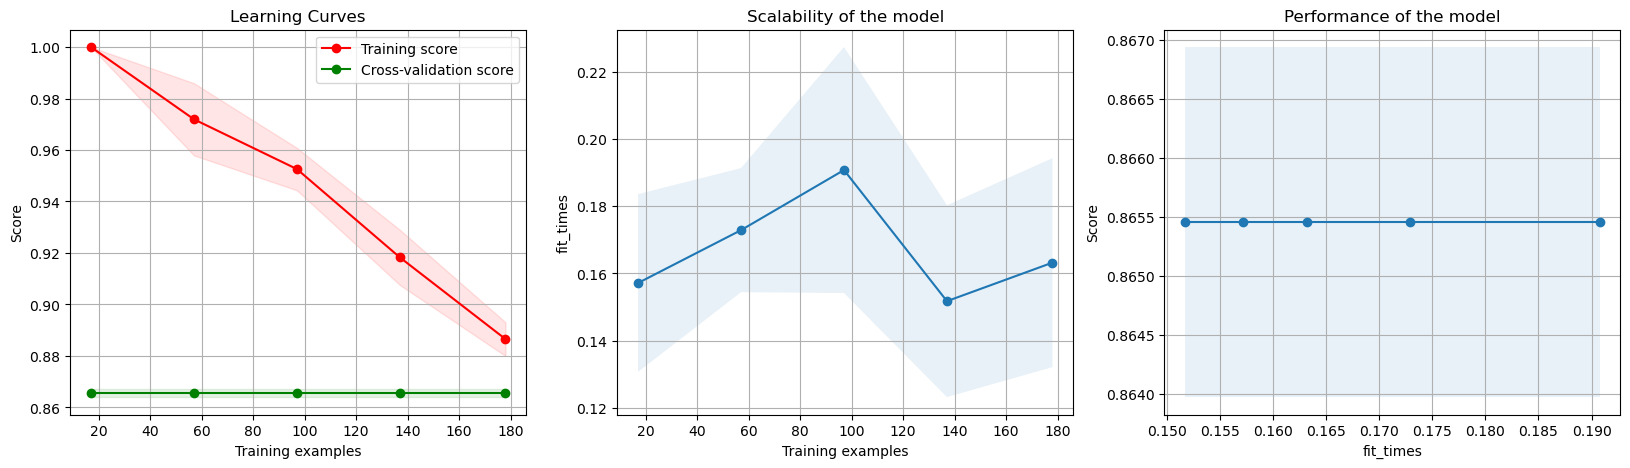

In [33]:
m1.plot()

In [34]:
classifier_2 = Pipeline([
        ('classifier', RandomForestClassifier()),])
param_classifier_2 = {
    'classifier__max_depth':[5,15,50,None],
    'classifier__n_estimators':[10,100,200],
    'classifier__max_features':[1,5,10,None],
    'classifier__min_samples_leaf':[1,5,10]
}

m2=module(X,y,preprocessor_1,classifier_2,param_classifier_2,sparse=False,featurize=True)

In [35]:
feat_dict={
  'featurizer_items':[
    'count_words', # ham has not much words
    'count_characters',  # ham has not much words
    'count_characters_no_space',
    'avg_word_length',  # ham has not much words
    'count_numbers', # ham has not much words
    'count_sentences', # ham has not much words
    'noun_count',
    'aux_count',
    'verb_count',
    #'adj_count',   # both spam and ham has not much words
    'ner'
  ]
}
m2(**feat_dict)


/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Best cross-validation score: 0.72

Best parameters:  {'classifier__n_estimators': 200, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 10, 'classifier__max_depth': 15}

Best estimator:  Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, max_features=10,
                                        n_estimators=200))])
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00         8

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

[1. 1.]


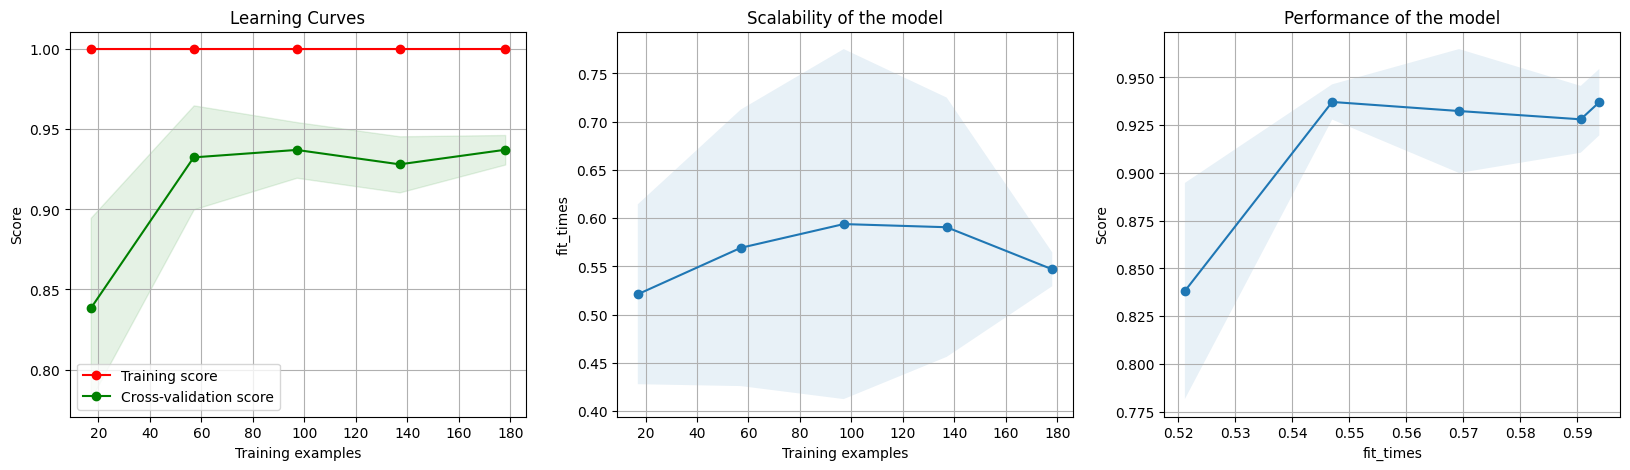

In [ ]:
m2.plot()

In [36]:
preprocessor_1=cp.SpacyPreprocessor(model='en_core_web_sm',
                                    batch_size = 500,
                                    lower=False,  # spam has CAPITAL cases
                                    remove_email=False, # spam has email address
                                    remove_url=False,)  # spam has url data
X=df_small['message'].tolist()
y=df_small['label'].tolist()
classifier_3 = None
param_classifier_3 =None

In [37]:
m3=module(X,y,preprocessor_1,classifier_3,param_classifier_3,sparse=True,featurize=True)

In [38]:
X_train, X_test, y_train, y_test=m3._preprocessing()

feat_dict={
  'featurizer_items':[
    'count_words', # ham has not much words
    'count_characters',  # ham has not much words
    'count_characters_no_space',
    'avg_word_length',  # ham has not much words
    'count_numbers', # ham has not much words
    'count_sentences', # ham has not much words
    'noun_count',
    'aux_count',
    'verb_count',
    #'adj_count',   # both spam and ham has not much words
    'ner'
  ]
}
X_train,X_test=m3._feature_engineering(X_train, X_test, y_train, y_test,**feat_dict)

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [39]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)


In [40]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")), ])
sparse_features.fit_transform(X_train.iloc[:, 1:])
vectorizer.fit_transform(X_train.iloc[:, 0])
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', RandomForestClassifier()),
                         ])
param_classifier_3 = {
    'combined_features__tfidf__tfidf__max_df':[0.5, 0.6, 0.7], # ignore terms which appears more than 0.X
    'combined_features__tfidf__tfidf__ngram_range':[(1, 1), (1, 2), (1,3),],
    #'combined_features__tfidf__tfidf__min_df':[0.1,0.5,1],
    'combined_features__tfidf__tfidf__max_features': [500, 1000, 5000],
    'classifier__max_depth':[5,15,50,None],
    'classifier__n_estimators':[10,100,200],
    'classifier__max_features':[1,5,10,None],
    'classifier__min_samples_leaf':[1,5,10]
}

In [ ]:
#list(classifier_3.get_params().keys())

In [41]:
m3=module(X,y,preprocessor_1,classifier_3,param_classifier_3,sparse=True,featurize=True)

In [42]:
feat_dict={
  'featurizer_items':[
    'count_words',
    'count_characters',
    'count_characters_no_space',
    'avg_word_length',
    'count_numbers',
    'count_sentences',
    'noun_count',
    'aux_count',
    'verb_count',
    #'adj_count',
    'ner'
  ]
}
m3(**feat_dict)

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Best cross-validation score: 0.64

Best parameters:  {'combined_features__tfidf__tfidf__ngram_range': (1, 3), 'combined_features__tfidf__tfidf__max_features': 1000, 'combined_features__tfidf__tfidf__max_df': 0.7, 'classifier__n_estimators': 100, 'classifier__min_samples_leaf': 5, 'classifier__max_features': None, 'classifier__max_depth': 5}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.7,
                                                                                   max_features=1000,
                                                                                   ngram_range=(1,
            

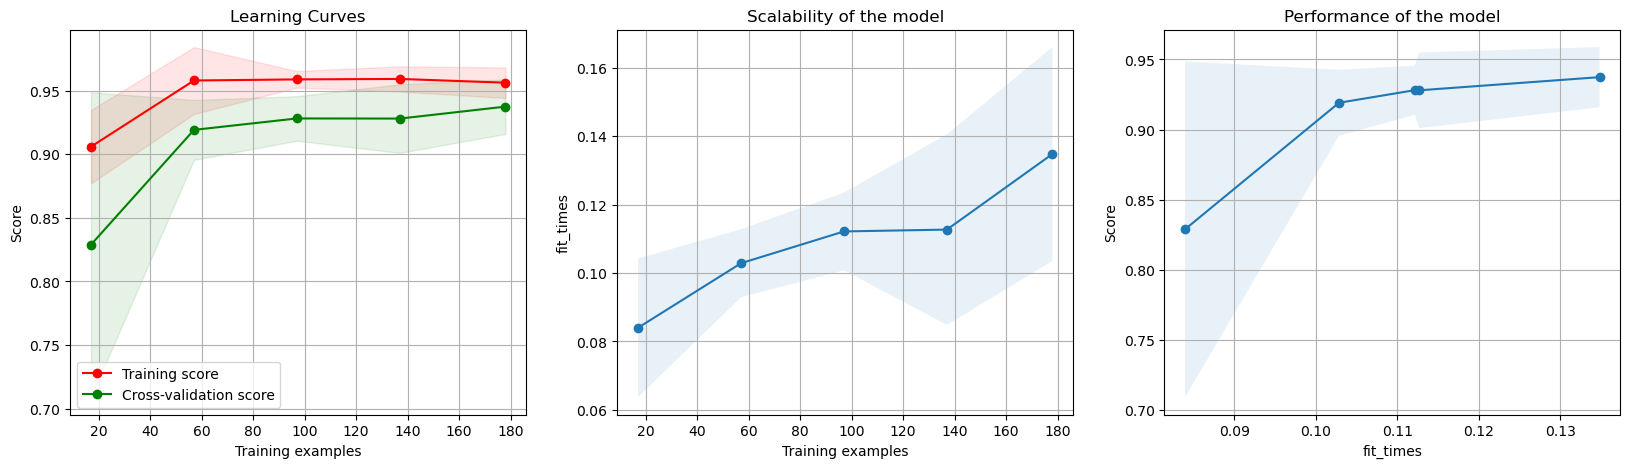

In [43]:
m3.plot()

# Model Selection
Finally, I selected the model3.
The model 1 had a poor result.
The model 2 showed a suspicious result in its learning curve. It seemed like overfitting.
The model 3 had no overfitting and cross validation score was good.

For this small dataset, I assumed prediction score is not the most important factor because of the quantity of data.